In [1]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LayerNormalization
#from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard

In [3]:
df = pd.read_csv ("/content/train.csv")
df = np.array(df)[:,1:]
df.shape

(745, 4)

In [4]:
df

array([[1.14388639e-02, 2.69056891e-03, 1.20643741e-03, 6.94671963e-03],
       [6.31663784e-04, 7.27739554e-03, 4.04865224e-03, 7.44992466e-05],
       [1.78279555e-02, 2.82101461e-02, 7.75795818e-03, 7.38221318e-03],
       ...,
       [7.68299427e-03, 1.95758627e-03, 7.00224191e-03, 6.46675926e-03],
       [3.39558900e-03, 1.27959071e-03, 7.62073818e-03, 1.68006760e-03],
       [4.59119924e-03, 6.67492170e-03, 7.59995590e-03, 9.55986473e-03]])

In [5]:
random.shuffle(df)
train_features = df[:335]
train_labels = np.zeros(335)

test_features = df[335:]
test_labels  = np.zeros(410)

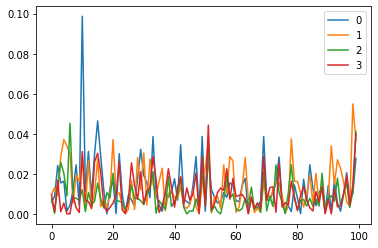

In [8]:
def sample_data(n_samples=100):
    index = np.random.randint(len(df), size=(1, n_samples))
    vectors = df[index,:]
    return vectors

ax = pd.DataFrame(sample_data(100)[0]).plot()

In [39]:
def get_generative(G_in, dense_dim=50, out_dim=10, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='relu')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[1,4])
G, G_out = get_generative(G_in)
G.summary()


Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1, 4)]            0         
_________________________________________________________________
dense_24 (Dense)             (None, 1, 50)             250       
_________________________________________________________________
activation_10 (Activation)   (None, 1, 50)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 1, 10)             510       
Total params: 760
Trainable params: 760
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
# Code sticks here yet is a good start


def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=1000, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='sigmoid')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[1,4])
D, D_out = get_discriminative(D_in)
D.summary()

ValueError: ignored

In [14]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([100])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model_1 (Functional)         (None, 100)               20200     
_________________________________________________________________
model_3 (Functional)         (None, 100)               245450    
Total params: 265,650
Trainable params: 20,200
Non-trainable params: 245,450
_________________________________________________________________


In [27]:
def sample_data_and_gen(G, noise_dim=4, n_samples=100):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    print(len(XT),len(XN_noise),len(XN))
    print(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=100, n_samples=100, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)

1 100 100
[[0.31503922 0.54555864 0.09067201 ... 0.3848538  0.0627383  0.87052583]
 [0.19536109 0.14566343 0.71236526 ... 0.23096608 0.10871295 0.21935967]
 [0.18872429 0.01901171 0.972098   ... 0.53128289 0.17545253 0.43956469]
 ...
 [0.92811753 0.57119544 0.85529875 ... 0.40239382 0.78316254 0.68282197]
 [0.31878896 0.34213076 0.98512274 ... 0.26676256 0.09243574 0.74624367]
 [0.73405327 0.41693675 0.43047809 ... 0.6811925  0.34487816 0.61406093]]


ValueError: ignored

In [29]:
G.predict(0.33)

IndexError: ignored

In [ ]:
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

In [ ]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
